# Seasonality Based Recommender System

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection


import sklearn 
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

from collections import defaultdict
from surprise import SVD
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df=pd.read_csv("user_purchases.csv")

In [3]:
df.head()

,user-id,purchase-id,product-id,category,actual_price,discount,timestamp,location,rating,attribute2
0,125,1,67,Toys,592.67,6.59,27-07-2022 01:17,Los Angeles,2,4
1,422,2,81,Toys,754.43,304.89,02-05-2023 01:17,New York City,2,5
2,160,3,17,Groceries,437.24,70.77,16-06-2023 01:17,San Francisco,4,5
3,127,4,67,Sports,837.56,279.76,15-12-2022 01:17,San Francisco,1,2
4,433,5,27,Electronics,431.13,225.81,30-11-2022 01:17,San Francisco,3,4


#### Converting to Date and Time format to easily extract the desired month:

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [5]:
df.head()

,user-id,purchase-id,product-id,category,actual_price,discount,timestamp,location,rating,attribute2
0,125,1,67,Toys,592.67,6.59,2022-07-27 01:17:00,Los Angeles,2,4
1,422,2,81,Toys,754.43,304.89,2023-02-05 01:17:00,New York City,2,5
2,160,3,17,Groceries,437.24,70.77,2023-06-16 01:17:00,San Francisco,4,5
3,127,4,67,Sports,837.56,279.76,2022-12-15 01:17:00,San Francisco,1,2
4,433,5,27,Electronics,431.13,225.81,2022-11-30 01:17:00,San Francisco,3,4


In [6]:
df.dtypes

user-id                  int64
purchase-id              int64
product-id               int64
category                object
actual_price           float64
discount               float64
timestamp       datetime64[ns]
location                object
rating                   int64
attribute2               int64
dtype: object

In [7]:
shape_Data = df.shape
print('Data set contains "{x}" number of rows and "{y}" number of columns' .format(x=shape_Data[0],y=shape_Data[1]))

Data set contains "1000" number of rows and "10" number of columns


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user-id,1000.0,244.18000,144.778702,2.00,122.00,239.000,369.2500,500.00
purchase-id,1000.0,500.50000,288.819436,1.00,250.75,500.500,750.2500,1000.00
product-id,1000.0,49.93300,28.638238,1.00,26.00,49.500,75.0000,100.00
actual_price,1000.0,495.45157,278.514088,10.87,259.38,494.075,729.7375,998.04
discount,1000.0,192.04047,169.819648,0.14,54.66,140.235,288.2700,782.50
rating,1000.0,2.98800,1.422631,1.00,2.00,3.000,4.0000,5.00
attribute2,1000.0,2.94900,1.402272,1.00,2.00,3.000,4.0000,5.00


In [9]:
df.isnull().sum() #Making sure there's no null vales in the dataset

user-id         0
purchase-id     0
product-id      0
category        0
actual_price    0
discount        0
timestamp       0
location        0
rating          0
attribute2      0
dtype: int64

#### Checking the rating distributions:

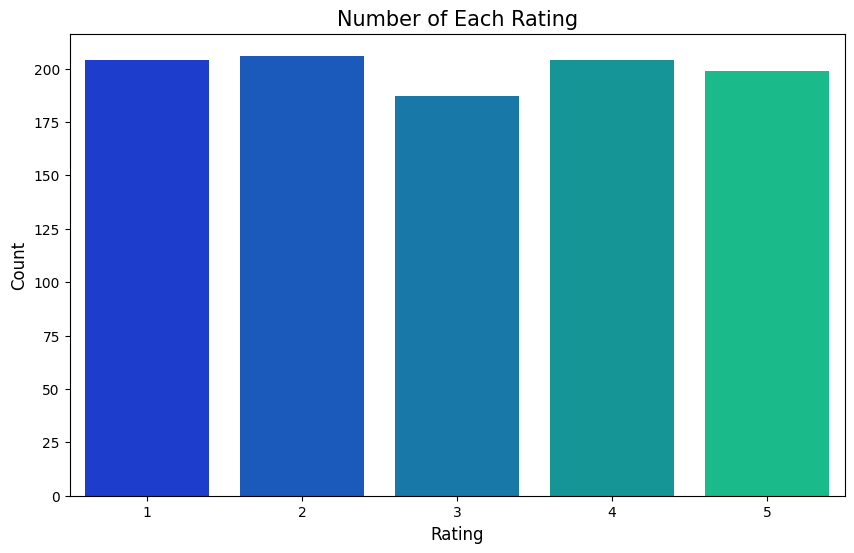

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(x='rating', data=df, palette='winter')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Number of Each Rating', fontsize=15)
plt.show()

#### Calculating the number of ratings and mean rating per product:

In [11]:
df_rating=pd.DataFrame({'Number of Rating':df.groupby('product-id').count()['rating'], 'Mean Rating':df.groupby('product-id').mean()['rating']})

In [12]:
df_rating.head()

,Number of Rating,Mean Rating
product-id,,
1,8,3.125000
2,3,3.000000
3,16,2.500000
4,7,3.142857
5,7,2.142857


In [13]:
df_rating.tail()

,Number of Rating,Mean Rating
product-id,,
96,11,2.909091
97,10,2.700000
98,5,2.600000
99,15,3.000000
100,8,2.375000


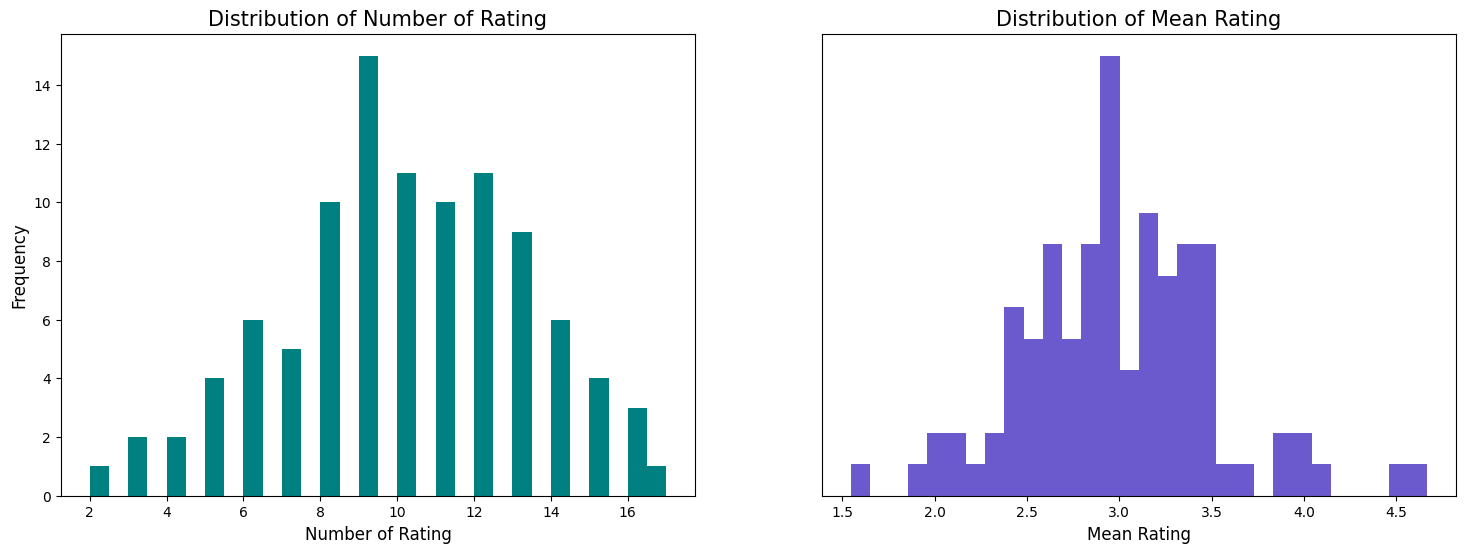

In [14]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.hist(x='Number of Rating',data=df_rating,bins=30,color='teal')
plt.title('Distribution of Number of Rating', fontsize=15)
plt.xlabel('Number of Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1,2,2)
plt.hist(x='Mean Rating',data=df_rating,bins=30, color='slateblue')
plt.title('Distribution of Mean Rating', fontsize=15)
plt.xlabel('Mean Rating', fontsize=12)
plt.yticks([])
plt.show()

<Figure size 800x600 with 0 Axes>

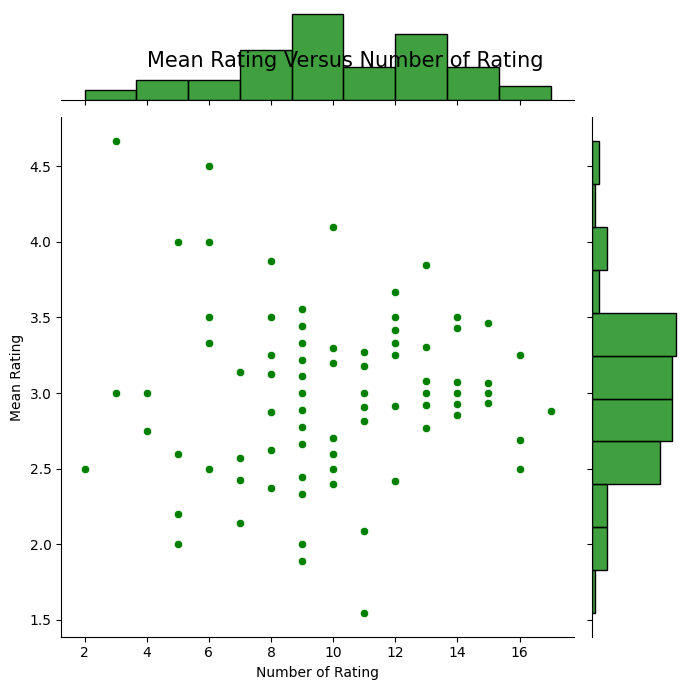

In [15]:
plt.figure(figsize=(8,6))
sns.jointplot(x='Number of Rating', y='Mean Rating',data=df_rating,color='g', height=7)
plt.suptitle('Mean Rating Versus Number of Rating', fontsize=15, y=0.92)

plt.show()

In [16]:
df_rating['Mean Rating'].mean()

2.9893887836020188

In [17]:
df_rating['Number of Rating'].quantile(q=0.9)

14.0

In [18]:
df_filtered=df_rating[df_rating['Number of Rating']>df_rating['Number of Rating'].quantile(q=0.9)]

In [19]:
df_filtered.head()

,Number of Rating,Mean Rating
product-id,,
3,16,2.500000
9,17,2.882353
10,16,3.250000
12,15,3.066667
46,15,2.933333


In [20]:
df_filtered.shape

(8, 2)

# Recommend Clothing Products Based on the Month

In [21]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

In [27]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user-id', 'product-id', 'actual_price']], reader)

In [28]:
trainset, testset = train_test_split(data, test_size=0.2)

In [29]:
algo = SVD()
algo.fit(trainset)

In [30]:
def recommend_products(user_id, target_month, category='Clothing', num_recommendations=10):
    # Filter data for the target month/season and category
    target_data = df[(df['timestamp'].dt.month == target_month) & (df['category'] == category)]

    # Create a list of unique product IDs
    product_ids = target_data['product-id'].unique()

    # Create a list of tuples containing (product_id, predicted_rating) for the user
    predictions = [(product_id, algo.predict(user_id, product_id).est) for product_id in product_ids]

    # Sort the predictions based on the predicted rating
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Get the top N recommended product IDs
    top_product_ids = [product_id for product_id, _ in predictions[:num_recommendations]]

    return top_product_ids

#### In this code, we use the Surprise library, which provides a high-level interface for building and evaluating recommendation systems. We convert our dataset into Surprise Dataset format, split the data into train and test sets, and train the SVD algorithm on the trainset. The recommend_products function filters the dataset based on the target month/season and predicts ratings for the user's interaction with each product. The products are then sorted based on the predicted rating, and the top N product IDs are returned as recommendations.

#### Usage:
#### Change the "num_recommendations" variable for desired number of recommendations in the "recommend_products" function arguments

In [31]:
user_id = 433 #User must input a user id and a month
target_month = 7
recommended_products = recommend_products(user_id, target_month)
print("Recommended products:", recommended_products)

Recommended products: [62, 77, 73, 53, 90, 8, 96, 1, 71, 30]


# Recommend Clothing Products Based on the Month by considering the rating factor 

In [32]:
# Function to recommend products based on the festive season, category, and rating threshold using collaborative filtering
def recommend_products(user_id, target_month, category='Clothing', rating_threshold=1, average_rating_threshold=2, num_recommendations=2):
    # Filter data for the target month and category
    target_data = df[(df['category'] == category) & (df['timestamp'].dt.month == target_month)]

    # Calculate the number of ratings for each product
    product_ratings_count = target_data['product-id'].value_counts()

    # Filter out products with ratings below the threshold
    target_data = target_data[target_data['product-id'].isin(product_ratings_count[product_ratings_count >= rating_threshold].index)]

    # Calculate the average rating for each product
    product_avg_ratings = target_data.groupby('product-id')['rating'].mean()

    # Filter out products with average rating below the threshold
    target_data = target_data[target_data['product-id'].isin(product_avg_ratings[product_avg_ratings >= average_rating_threshold].index)]

    # Create a pivot table with user-item interactions
    pivot_table = target_data.pivot_table(index='user-id', columns='product-id', values='rating', fill_value=0)

    # Get the list of qualified users
    qualified_users = pivot_table.index[pivot_table.sum(axis=1) >= num_recommendations]

    # Check if the user exists in the pivot table
    if user_id not in qualified_users:
        print(f"User with ID {user_id} does not have enough data for recommendations.")
        print("Qualified Users:")
        print(qualified_users)
        return []

    # Fit k-nearest neighbors model
    model = NearestNeighbors(metric='cosine', algorithm='brute')
    model.fit(pivot_table.values)

    # Find the index of the target user
    target_user_index = pivot_table.index.get_loc(user_id)

    # Find the k nearest neighbors
    distances, indices = model.kneighbors(pivot_table.iloc[target_user_index, :].values.reshape(1, -1), n_neighbors=num_recommendations)

    # Get the product recommendations from the nearest neighbors
    recommendations = []
    for index in indices.flatten():
        user = pivot_table.index[index]
        products = pivot_table.loc[user, :]
        top_product = products.idxmax()
        recommendations.append(top_product)

    return recommendations

#### In this code, the recommend_products function takes additional parameters for the rating threshold (rating_threshold) and the average rating threshold (average_rating_threshold). It first filters out the products that do not meet the minimum rating count requirement (rating_threshold). Then, it calculates the average rating for each product and filters out the products that have an average rating below the specified threshold (average_rating_threshold). The collaborative filtering process remains the same as before.

#### Usage:

In [33]:
user_id = 381
target_month = 7  # July
recommended_products = recommend_products(user_id, target_month)
print("Recommended products:", recommended_products)

Recommended products: [77, 8]


# On Amazon Dataset

In [34]:
column_names=['userId','productId','rating','timestamp']
df2=pd.read_csv('ratings_Electronics (1).csv',names=column_names)

In [35]:
import datetime

In [36]:
df2['timestamp'] = pd.to_datetime(df2['timestamp'], unit='s')
df2['timestamp'] = df2['timestamp'].dt.strftime('%d/%m/%Y')

In [37]:
df2.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,13/04/2013
1,A2CX7LUOHB2NDG,0321732944,5.0,01/07/2012
2,A2NWSAGRHCP8N5,0439886341,1.0,29/04/2013
3,A2WNBOD3WNDNKT,0439886341,3.0,22/07/2013
4,A1GI0U4ZRJA8WN,0439886341,1.0,18/04/2012


In [38]:
df2_rating=pd.DataFrame({'Number of Rating':df2.groupby('productId').count()['rating'], 'Mean Rating':df2.groupby('productId').mean()['rating']})

In [39]:
df2_rating.head()

,Number of Rating,Mean Rating
productId,,
0132793040,1,5.000000
0321732944,1,5.000000
0439886341,3,1.666667
0511189877,6,4.500000
0528881469,27,2.851852


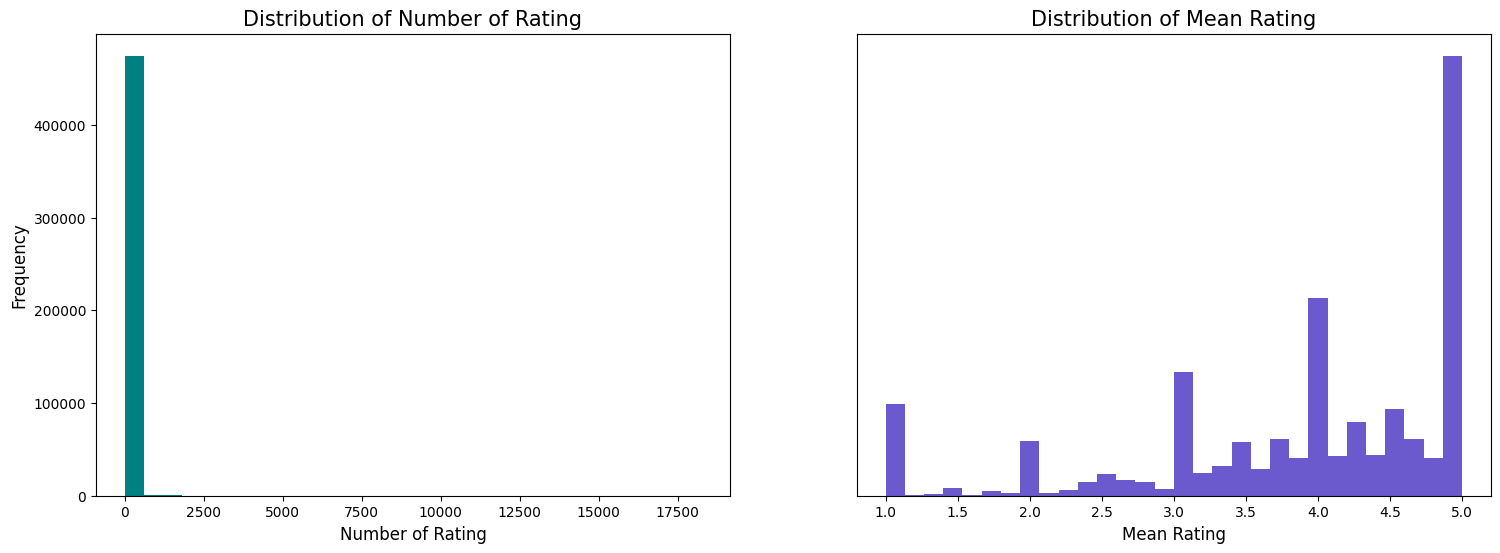

In [40]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.hist(x='Number of Rating',data=df2_rating,bins=30,color='teal')
plt.title('Distribution of Number of Rating', fontsize=15)
plt.xlabel('Number of Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1,2,2)
plt.hist(x='Mean Rating',data=df2_rating,bins=30, color='slateblue')
plt.title('Distribution of Mean Rating', fontsize=15)
plt.xlabel('Mean Rating', fontsize=12)
plt.yticks([])
plt.show()

<Figure size 800x600 with 0 Axes>

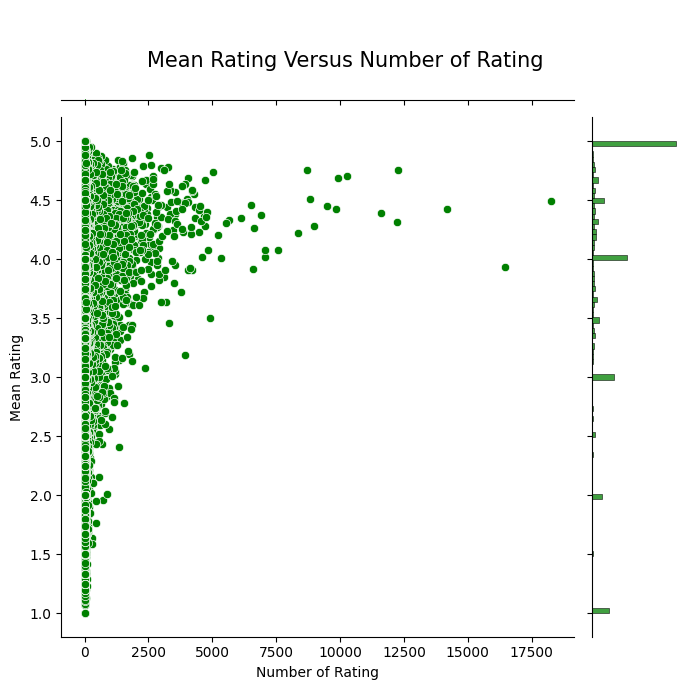

In [41]:
plt.figure(figsize=(8,6))
sns.jointplot(x='Number of Rating', y='Mean Rating',data=df2_rating,color='g', height=7)
plt.suptitle('Mean Rating Versus Number of Rating', fontsize=15, y=0.92)

plt.show()

In [38]:
df2_rating['Mean Rating'].mean()

3.889700263013201

In [39]:
df2_rating['Number of Rating'].quantile(q=0.9)

25.0

In [40]:
df2['timestamp'] = pd.to_datetime(df2['timestamp'])

In [41]:
df2.dtypes

userId               object
productId            object
rating              float64
timestamp    datetime64[ns]
dtype: object

In [42]:
df2.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,2013-04-13
1,A2CX7LUOHB2NDG,0321732944,5.0,2012-01-07
2,A2NWSAGRHCP8N5,0439886341,1.0,2013-04-29
3,A2WNBOD3WNDNKT,0439886341,3.0,2013-07-22
4,A1GI0U4ZRJA8WN,0439886341,1.0,2012-04-18


In [43]:
def recommend_products(user_id, target_month, rating_threshold=10, average_rating_threshold=3, num_recommendations=10):
    # Filter data for the target month
    target_data = df2[df2['timestamp'].dt.month == target_month]

    # Calculate the number of ratings for each user
    user_ratings_count = target_data['userId'].value_counts()

    # Filter out users with ratings below the threshold
    target_data = target_data[target_data['userId'].isin(user_ratings_count[user_ratings_count >= rating_threshold].index)]

    # Calculate the average rating for each user
    user_avg_ratings = target_data.groupby('userId')['rating'].mean()

    # Filter out users with average rating below the threshold
    target_data = target_data[target_data['userId'].isin(user_avg_ratings[user_avg_ratings >= average_rating_threshold].index)]

    # Create a pivot table with user-item interactions
    pivot_table = target_data.pivot_table(index='userId', columns='productId', values='rating', fill_value=0)

    # Check if the target user exists in the pivot table
    if user_id not in pivot_table.index:
        print(f"User with ID {user_id} does not have enough data for recommendations.")
        qualified_users = pivot_table.index.tolist()
        print("Qualified Users:")
        print(qualified_users)
        return []

    # Fit k-nearest neighbors model
    model = NearestNeighbors(metric='cosine', algorithm='brute')
    
    try:
        model.fit(pivot_table.values)
    except ValueError as e:
        print("ValueError: {}".format(str(e)))
        qualified_users = pivot_table.index.tolist()
        print("Qualified Users:")
        print(qualified_users)
        return []

    # Find the index of the target user
    target_user_index = pivot_table.index.get_loc(user_id)

    # Find the k nearest neighbors
    distances, indices = model.kneighbors(pivot_table.iloc[target_user_index, :].values.reshape(1, -1), n_neighbors=num_recommendations)

    # Get the product recommendations from the nearest neighbors
    recommendations = []
    for index in indices.flatten():
        user = pivot_table.index[index]
        products = pivot_table.loc[user, :]
        top_product = products.idxmax()
        recommendations.append(top_product)

    return recommendations

#### Adjust the rating_threshold and average_rating_threshold parameters according to your desired thresholds.

#### Usage:

In [44]:
user_id = "A3OA4DV4L81N1D"
target_month = 7
recommended_products = recommend_products(user_id, target_month, rating_threshold=10, average_rating_threshold=3)
print("Recommended products:", recommended_products)

Recommended products: ['B000BSLS0W', 'B002MAPSQM', 'B008JJLW4M', 'B002WE4HE2', 'B0014E02AO', 'B000067S60', 'B00000J1V5', 'B00006JN3G', 'B00004ZCDD', 'B00006I5JM']


# Adding Weather and Festival Data

In [51]:
# Function to assign festivals based on timestamp
def assign_festival(timestamp):
    month = timestamp.month
    if month == 1:
        return "New Year's Day"
    elif month == 2:
        return "Valentine's Day"
    elif month == 3:
        return "Holi"
    elif month == 4:
        return "Easter"
    elif month == 5:
        return "Cinco de Mayo"
    elif month == 6:
        return "Father's Day"
    elif month == 7:
        return "Independence Day"
    elif month == 8:
        return "Raksha Bandhan"
    elif month == 9:
        return "Ganesh Chaturthi"
    elif month == 10:
        return "Durga Puja"
    elif month == 11:
        return "Diwali"
    elif month == 12:
        return "Christmas"
    else:
        return "No Festival"  # Assign "No Festival" for other months


In [52]:
# Function to assign weather attribute based on timestamp
def assign_weather(timestamp):
    month = timestamp.month
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Summer"
    elif month in [6, 7, 8]:
        return "Rainy"
    elif month in [9, 10, 11]:
        return "Spring"
    else:
        return "Unknown"  # Assign "Unknown" for other months

In [53]:
# Iterate over each row in the DataFrame and assign festival and weather attributes
#for index, row in df2.iterrows():
 #   timestamp = row['timestamp']
    
    # Assign festival based on timestamp
  #  festival = assign_festival(timestamp)
    
    # Assign weather attribute based on timestamp
   # weather = assign_weather(timestamp)

    # Assign festival and weather attributes to the corresponding row
    #df2.at[index, 'festival'] = festival
    #df2.at[index, 'weather'] = weather

In [54]:
#output_file = 'updated_dataset.csv'
#df2.to_csv(output_file, index=False)

In [128]:
df3=pd.read_csv('updated_dataset.csv')

In [130]:
df3.head()

In [5]:
df3['timestamp'] = pd.to_datetime(df3['timestamp'])

In [6]:
df3.dtypes

userId               object
productId            object
rating              float64
timestamp    datetime64[ns]
festival             object
weather              object
dtype: object

In [7]:
import scipy.sparse as sp

In [8]:
from hnswlib import Index

In [9]:
from surprise import Dataset
from surprise import Reader
from surprise import KNNBasic
from surprise.model_selection import train_test_split

#### We sampled the dataset because the dataset is too large and we had to avoid the memory error

In [75]:
sample_fraction = 0.01

In [76]:
df4 = df3.sample(frac=sample_fraction, random_state=42)

In [77]:
df4.head()

,userId,productId,rating,timestamp,festival,weather
1157290,A1Z3YJF1S8Z1M3,B000M9ISQ2,5.0,2008-08-01,Raksha Bandhan,Rainy
2677500,ALDXDYEGKB27G,B002L6HE9G,4.0,2012-10-03,Durga Puja,Spring
5814180,A15LOGO6NBSI6B,B007MXGG5Q,5.0,2013-01-20,New Year's Day,Winter
6239751,A23LX12CA3G4FG,B008HOEDYU,1.0,2013-11-25,Diwali,Spring
5344316,A3TV7QFYXAG130,B0069R7TAM,5.0,2014-06-17,Father's Day,Rainy


In [78]:
df4.tail()

,userId,productId,rating,timestamp,festival,weather
3064391,A1TWH3KD5YJQHM,B0035ERKYW,5.0,2012-11-09,Diwali,Spring
4388940,AMXTPQY23TN07,B004RB8CT4,4.0,2013-03-05,Holi,Summer
2691677,A1FCG75OIMKQCT,B002LTWDSK,2.0,2013-01-08,New Year's Day,Winter
4332919,A2X2NI89D5BQ2E,B004P1V8TM,5.0,2014-02-19,Valentine's Day,Winter
390062,A2VAZBUX99XIWP,B0001FTVEK,5.0,2013-05-01,Cinco de Mayo,Summer


In [79]:
print("Sampled dataset size:", len(df4))

Sampled dataset size: 78245


In [80]:
target_festival = None #Input either a festival name or a weather condition
target_weather = "Summer"
avg_rating_threshold = 3.5  # Minimum average rating threshold
num_ratings_threshold = 10  # Minimum number of ratings threshold

In [81]:
if target_weather:
    filtered_data = df4[df4['weather'] == target_weather]
else:
    filtered_data = df4[df4['festival'] == target_festival]

In [82]:
product_stats = filtered_data.groupby('productId').agg({'rating': ['mean', 'count']})
product_stats.columns = ['avg_rating', 'num_ratings']

In [83]:
filtered_products = product_stats[
    (product_stats['avg_rating'] >= avg_rating_threshold) &
    (product_stats['num_ratings'] >= num_ratings_threshold)]

In [84]:
filtered_data = filtered_data[filtered_data['productId'].isin(filtered_products.index)]

In [85]:
reader = Reader(rating_scale=(1, 5))

In [86]:
dataset = Dataset.load_from_df(filtered_data[['userId', 'productId', 'rating']], reader)

In [87]:
trainset, testset = train_test_split(dataset, test_size=0.2)

In [88]:
algo = KNNBasic()

In [89]:
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [90]:
predictions = algo.test(testset)

In [132]:
user_id = 'A2X2NI89D5BQ2E'
top_n = 5  # Number of recommendations to generate

In [133]:
user_items = filtered_data.loc[filtered_data['userId'] == user_id, 'productId']
all_items = filtered_data['productId'].unique()
items_to_predict = list(set(all_items) - set(user_items))

In [134]:
user_predictions = [algo.predict(user_id, item_id) for item_id in items_to_predict]

In [135]:
sorted_predictions = sorted(user_predictions, key=lambda x: x.est, reverse=True)

In [136]:
recommended_items = [pred.iid for pred in sorted_predictions[:top_n]]

In [137]:
print("Top {} recommended items for user {}: {}".format(top_n, user_id, recommended_items))

Top 5 recommended items for user A2X2NI89D5BQ2E: ['B001XURP7W', 'B004QK7HI8', 'B0057OCDQS', 'B005DKZTMG', 'B00622AG6S']


# For Electronic Dataset

In [42]:
electronics=pd.read_csv("kz.csv")

In [43]:
electronics.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
2,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
3,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
4,2020-04-24 19:16:21 UTC,2294584263154074236,2273948316817424439,2.268105e+18,NaN,karcher,217.57,1.515916e+18


In [44]:
electronics['category_id'] = pd.to_numeric(electronics['category_id'])

In [45]:
electronics['category_id'] = electronics['category_id'].astype(float)

In [46]:
electronics.dtypes

event_time        object
order_id           int64
product_id         int64
category_id      float64
category_code     object
brand             object
price            float64
user_id          float64
dtype: object

In [47]:
electronics['event_time'] = pd.to_datetime(electronics['event_time'])

In [48]:
electronics.dtypes

event_time       datetime64[ns, UTC]
order_id                       int64
product_id                     int64
category_id                  float64
category_code                 object
brand                         object
price                        float64
user_id                      float64
dtype: object

In [49]:
electronics.isnull().sum()

event_time             0
order_id               0
product_id             0
category_id       431954
category_code     612202
brand             506005
price             431954
user_id          2069352
dtype: int64

In [50]:
electronics.dropna(inplace=True)

In [51]:
electronics.shape

(420718, 8)

In [52]:
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

In [53]:
electronics['month'] = electronics['event_time'].dt.month

In [54]:
reader = Reader(rating_scale=(0, 1))

In [55]:
reader.rating_scale = (0, 1)

In [56]:
data = Dataset.load_from_df(electronics[['user_id', 'product_id', 'month']], reader)

In [57]:
trainset, testset = train_test_split(data, test_size=0.2)

In [58]:
model = SVD()

In [59]:
model.fit(trainset)

In [60]:
predictions = model.test(testset)

In [61]:
accuracy.rmse(predictions)

RMSE: 7.1833


7.183297553569779

In [62]:
def get_recommendations(user_id, month):
    products_already_bought = electronics[(electronics['user_id'] == user_id) & (electronics['month'] == month)]['product_id'].tolist()
    all_products = electronics[electronics['month'] == month]['product_id'].unique().tolist()
    products_to_recommend = [p for p in all_products if p not in products_already_bought]

    recommendations = []
    for product_id in products_to_recommend:
        prediction = model.predict(user_id, product_id)
        recommendations.append((product_id, prediction.est))

    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations

#### The code uses the Surprise library's SVD algorithm for collaborative filtering, and it recommends products for a given user based on the month extracted from the event_time column. The get_recommendations() function takes a user_id and a month as input and returns the top recommended products for that user in the given month.

In [67]:
import random

In [68]:
random_user_id = random.choice(electronics['user_id'].unique().tolist())

In [69]:
print(random_user_id)

1.5159156254820677e+18


#### Usage:

In [130]:
user_id = random_user_id #user_id is too lengthy to manually enter. Hence a random user_id is picked.
month = 9
recommendations = get_recommendations(user_id, month)
print("Recommended Products:")
for product_id, predicted_rating in recommendations[:5]:
    print(f"Product ID: {product_id}, Predicted Rating: {predicted_rating}")

Recommended Products:
Product ID: 1515966223509089425, Predicted Rating: 1
Product ID: 1515966223509089067, Predicted Rating: 1
Product ID: 1515966223509260711, Predicted Rating: 1
Product ID: 1515966223509301740, Predicted Rating: 1
Product ID: 1515966223509267365, Predicted Rating: 1


# For Groceries Dataset

In [3]:
groc=pd.read_csv("Groceries_dataset.csv")

In [4]:
groc.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [6]:
groc.isnull().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [7]:
groc.dtypes

Member_number       int64
Date               object
itemDescription    object
dtype: object

In [8]:
groc['Date'] = pd.to_datetime(groc['Date'])

In [9]:
groc.head()

,Member_number,Date,itemDescription
0,1808,2015-07-21,tropical fruit
1,2552,2015-05-01,whole milk
2,2300,2015-09-19,pip fruit
3,1187,2015-12-12,other vegetables
4,3037,2015-01-02,whole milk


In [10]:
groc.dtypes

Member_number               int64
Date               datetime64[ns]
itemDescription            object
dtype: object

In [172]:
groc['Month'] = pd.to_datetime(groc['Date']).dt.month

In [173]:
item_mapping = {item: idx for idx, item in enumerate(groc['itemDescription'].unique())}
groc['item_id'] = groc['itemDescription'].map(item_mapping)

In [174]:
reader = Reader(rating_scale=(1, 10))

In [175]:
data = Dataset.load_from_df(groc[['Member_number', 'item_id', 'Month']], reader)

In [177]:
trainset, _ = train_test_split(data, test_size=0.2)

In [178]:
algo = SVD()

In [187]:
algo.fit(trainset)

In [191]:
def get_recommendations(member_number, month, top_n=10):
    # Get all item IDs
    all_item_ids = set(groc['item_id'])
    
    # Get items that the user has already interacted with in the given month
    user_purchases = groc[(groc['Member_number'] == member_number) & (groc['Month'] == month)]['item_id']
    
    # Get items that the user has not interacted with in the given month
    items_to_predict = list(all_item_ids - set(user_purchases))
    
    # Make predictions for the user on the items to predict
    predictions = [algo.predict(member_number, item_id).est for item_id in items_to_predict]
    
    # Sort items based on predicted ratings (higher ratings mean better recommendations)
    items_sorted = [item_id for _, item_id in sorted(zip(predictions, items_to_predict), reverse=True)]
    
    # Get the itemDescription for recommended items
    recommended_items = [item for item, idx in item_mapping.items() if idx in items_sorted]
    return recommended_items[:top_n]


#### With this code, we use the Surprise library to perform SVD-based matrix factorization and generate recommendations for users in a given month. The algorithm predicts ratings for items the user has not interacted with in the given month and recommends items with the highest predicted ratings.

#### Printing all qualified users for a given month:

In [205]:
month = 1
qualified_users = groc[groc['Month'] == month]['Member_number'].unique()
print(f"Qualified users for month {month}: {', '.join(map(str, qualified_users))}") 

Qualified users for month 1: 3037, 1420, 4918, 3365, 1967, 2270, 1587, 3111, 4155, 1661, 1127, 3221, 3649, 3954, 3795, 4787, 3310, 1232, 1107, 2749, 2912, 3332, 2473, 2870, 3283, 4088, 4694, 1760, 4099, 2600, 3379, 3245, 1001, 4073, 2962, 2659, 2630, 4212, 2622, 1897, 1537, 2254, 4095, 3713, 3869, 1483, 3950, 1634, 1766, 4415, 2840, 2690, 4369, 3483, 4338, 4778, 1946, 4826, 1918, 2096, 3120, 1827, 4683, 4616, 3842, 2716, 1335, 3601, 2641, 1902, 3452, 4864, 3284, 1401, 4171, 2700, 1930, 4440, 4986, 3473, 4326, 1990, 4560, 1273, 4321, 1293, 2267, 4993, 1815, 4363, 2211, 2297, 3311, 3085, 3538, 3549, 3857, 4677, 4368, 1481, 4719, 1516, 3518, 4537, 2399, 4133, 2245, 3289, 3465, 3072, 2120, 2386, 4274, 3101, 3553, 3846, 4496, 3298, 2074, 2356, 2655, 2777, 1144, 4217, 4296, 2517, 2735, 2304, 2243, 3532, 3176, 3768, 3390, 1616, 3500, 3940, 3793, 4647, 4838, 3354, 1075, 1371, 1615, 2381, 3200, 2347, 4573, 1324, 2971, 2632, 1164, 3982, 2100, 3337, 3078, 4116, 4121, 1824, 3471, 2335, 1773, 3143,

#### Usage:

In [207]:
member_number = 3031
recommendations = get_recommendations(member_number, month)
if recommendations:
    print(f"\nRecommended products for member {member_number} in month {month}:")
    for i, item_description in enumerate(recommendations):
        print(f"{i+1}. {item_description}")
else:
    print(f"No recommendations for member {member_number} in month {month}.")


Recommended products for member 3031 in month 1:
1. tropical fruit
2. pip fruit
3. other vegetables
4. rolls/buns
5. pot plants
6. citrus fruit
7. beef
8. frankfurter
9. chicken
10. butter
